# 1.0 Full Exploratory Data Analysis


## Libraries


In [24]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import final_project.utils.paths as path
import janitor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [26]:
path.hello()


Helloooo


## Download data


### Specify input and output files


In [27]:
covid_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

covid_file = path.data_raw_dir("time_series_covid19_confirmed_global.csv")


### Run download


In [28]:
!curl {covid_url} - o {covid_file}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  876k  100  876k    0     0   303k      0  0:00:02  0:00:02 --:--:--  303k


## Process data


### Read data


In [29]:
input_covid_file = path.data_raw_dir(
    "time_series_covid19_confirmed_global.csv")


In [30]:
covid_df = pd.read_csv(input_covid_file)
covid_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Columns: 650 entries, Province/State to 10/28/21
dtypes: float64(2), int64(646), object(2)
memory usage: 1.4+ MB


In [31]:
covid_df.head()


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/19/21,10/20/21,10/21/21,10/22/21,10/23/21,10/24/21,10/25/21,10/26/21,10/27/21,10/28/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,155801,155859,155891,155931,155940,155944,156040,156071,156124,156166
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,178804,179463,180029,180623,181252,181696,181960,182610,183282,183873
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,205453,205529,205599,205683,205750,205822,205903,205990,206069,206160
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,15369,15382,15382,15404,15404,15404,15425,15425,15462,15505
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,63197,63340,63567,63691,63775,63861,63930,64033,64126,64226


### Process data


In [33]:
processed_df = (
    covid_df
    .select_columns(["Country/Region", "*/*/*"])
    .pivot_longer(
        index="Country/Region",
        names_to="date"
    )
    .transform_column("date", pd.to_datetime)
    .clean_names()
)

processed_df.head()


,country_region,date,value
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0


### Save output data


In [34]:
output_covid_file = path.data_processed_dir(
    "time_series_covid19_confirmed_global_processed.csv")


In [35]:
processed_df.to_csv(output_covid_file, index=False)


## Explore data


### Read data


In [36]:
processed_covid_file = path.data_processed_dir(
    "time_series_covid19_confirmed_global_processed.csv")


In [37]:
processed_covid_df = pd.read_csv(processed_covid_file)
processed_covid_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180234 entries, 0 to 180233
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   country_region  180234 non-null  object
 1   date            180234 non-null  object
 2   value           180234 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.1+ MB


In [38]:
processed_covid_df.head()


,country_region,date,value
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0


### Explore data


In [39]:
sns.set_style("whitegrid")


In [40]:
processed_covid_df = (
    processed_covid_df
    .transform_column(
        "date",
        pd.to_datetime
    )
)


#### Appearance of new covid-19 cases in Latam


Subset data.


In [41]:
countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Mexico', 'Peru']
some_latam_countries_df = processed_covid_df.filter_on(
    f"country_region in {countries}")
some_latam_countries_df.head(3)


,country_region,date,value
6,Argentina,2020-01-22,0
30,Brazil,2020-01-22,0
57,Chile,2020-01-22,0


Plot time series.


In [75]:
import final_project.visualization.visualize as visual

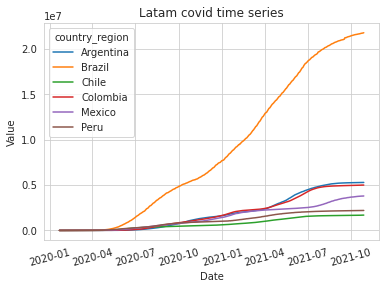

In [84]:
visual.covid_time_series(some_latam_countries_df)

Text(0.5, 1.0, 'Latam covid time series')

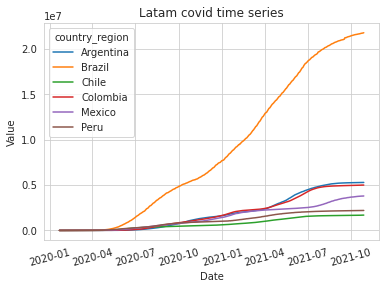

In [78]:
sns.lineplot(
    data=some_latam_countries_df,
    x="date",
    y="value",
    hue="country_region"
)

plt.xticks(rotation=15)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Latam covid time series")


#### Latam in global context


Top `n` countries.


In [79]:
top_countries_df = (
    processed_covid_df
    .select_columns(["country_region", "value"])
    .groupby(["country_region"])
    .aggregate("sum")
    .sort_values("value", ascending=False)
    .reset_index()
    .head(20)
    .transform_column(
        column_name="country_region",
        function=lambda x: "red" if x in countries else "lightblue",
        dest_column_name="color"
    )
)

top_countries_df.head()


,country_region,value,color
0,US,11845027273,lightblue
1,India,8086378883,lightblue
2,Brazil,5683494400,red
3,Russia,1911674585,lightblue
4,France,1839189755,lightblue


Plot to Latam in highlighted bars.


In [80]:
def latam_countries(df):
    sns.barplot(
        data=df,
        x="value",
        y="country_region",
        palette=df.color
    )

    plt.xlabel("Value")
    plt.ylabel("Country Region")
    plt.title("Latam countries in a global context")


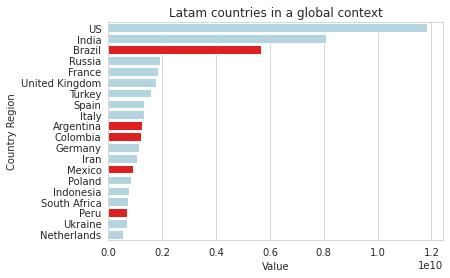

In [81]:
latam_countries(top_countries_df)

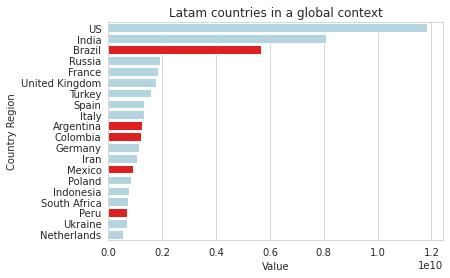

In [82]:
visual.latam_countries(top_countries_df)

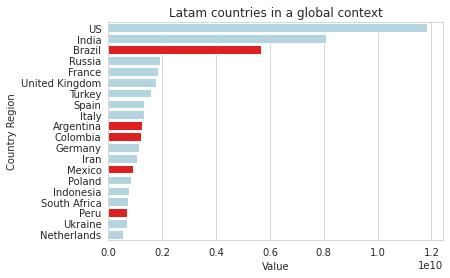

In [44]:

sns.barplot(
    data=top_countries_df,
    x="value",
    y="country_region",
    palette=top_countries_df.color
)

plt.xlabel("Value")
plt.ylabel("Country Region")
plt.title("Latam countries in a global context")
